# Keras实现Kaggle面部定点

这是我学习[这篇博文](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html)时候的代码复现, 感谢原作者[Daniel Nouri]((http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)基于[Lasagne](https://github.com/benanne/Lasagne)（[Theano](http://deeplearning.net/software/theano/)的高级框架）的实现，也感谢[真也雪](https://twitter.com/tuntuku_sy)将其迁移到Keras框架里。

## 数据集

[Kaggle数据集点此下载](https://www.kaggle.com/c/facial-keypoints-detection/data)

dataset  | num   | resolution | color     | keypoints
---      | ---   | ---        | ---       | ---
Training | 7049  | 96x96      | grayscale | 15

![定点示例](image_1.png)
3个点的定点示例

## 载入数据集

图像在csv文件“Image”栏以空格分隔像素点，其余栏为定点数据。测试集仅有图像数据，无定点数据

In [1]:
# dependencies

import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

# loading training and testing data from csv

FTRAIN = 'training.csv'
FTEST  = 'test.csv'

def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)    # pandas 读入数据

    # 将'Image'列以空格作为分隔符，转换成 np 数组
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # 只留下'Image'和给定的列
        df = df[list(cols) + ['Image']]

    print(df.count())       # 每一列包含值的个数
    df = df.dropna()        # 丢弃空行，只留下所有点都有的行

    # 将'image' np 数组从水平一行变成垂直一列堆叠，再归一化（灰度值0-255）
    # numpy 堆叠理解见 http://blog.csdn.net/csdn15698845876/article/details/73380803
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)            # 转换成32位浮点数组（为什么）

    if not test:                        # 只有训练集有点坐标
        y = df[df.columns[:-1]].values  # 除了'Image'一栏都是训练数据
        y = (y - 48) / 48   # （把原点定在图像中心）坐标值缩放到[-1, 1](from[0,95])
        X, y = shuffle(X, y,            # 打乱训练数据，(X,y)依然对应
                       random_state=42) # random.seed
        y = y.astype(np.float32)        # 转换成32位浮点数组（为什么）
    else:
        y = None

    return X, y                         # 返回训练集和标记np数组

In [2]:
# loading data

X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
      X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
      y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

### 解释

1. dropna()之后只有2140样本，但是96x96=9216 input dimension 会远大于样本数量，容易导致过拟合。
1. 将X,y均归一化有利于防止算法异常（y放到[-1，1]可以用softmax?）
1. np.stack, np.hstack, np.vstack [用法和理解见这篇微博](http://blog.csdn.net/csdn15698845876/article/details/73380803)，scikit-learn的shuffle函数打乱后X,y的对应关系不会变（坐标还是对应原来图像）


## Model 1 - 单隐藏层NN

A simple NN with only one hidden layer consumes less CPU time

In [3]:
# 1-hidden-layer NN

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()                # 建立顺序网络（简单的网络结构）
model.add(Dense(100,                # 中间全连接层，100个神经元
                input_dim=9216))    # 单个样本X的Shape，输入图像的像素数
model.add(Activation('relu'))       # 激活函数用Relu
model.add(Dense(30))                # 输出全连接层，30单元，单个y的Shape，15个点30个坐标

sgd = SGD(lr=0.01,                  # 自定义优化器
          momentum=0.9, 
          nesterov=True)
model.compile(loss='mean_squared_error', # 损失函数
              optimizer=sgd)             # 自定义的优化器
model.summary()                          # 显示网络结构
hist = model.fit(X, y, 
                 epochs=100,             # 训练轮数
                 validation_split=0.2)   # 20%的训练样本用于验证

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 1s 422us/step - loss: 0.0561 - val_loss: 0.0147
Epoch 2/100
1712/1712 [==============================] - 0s 288us/step - loss: 0.0131 - val_loss: 0.0111
Epoch 3/100
1712/1712 [==============================] - 1s 301us/step - loss: 0.0110 - val_loss: 0.0123
Epoch 4/100
1712/1712 [===============

1712/1712 [==============================] - 0s 288us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 72/100
1712/1712 [==============================] - 0s 281us/step - loss: 0.0028 - val_loss: 0.0036
Epoch 73/100
1712/1712 [==============================] - 0s 287us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 74/100
1712/1712 [==============================] - 1s 305us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 75/100
1712/1712 [==============================] - 1s 302us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 76/100
1712/1712 [==============================] - 0s 289us/step - loss: 0.0026 - val_loss: 0.0036
Epoch 77/100
1712/1712 [==============================] - 0s 289us/step - loss: 0.0026 - val_loss: 0.0035
Epoch 78/100
1712/1712 [==============================] - 0s 286us/step - loss: 0.0026 - val_loss: 0.0047
Epoch 79/100
1712/1712 [==============================] - 1s 298us/step - loss: 0.0026 - val_loss: 0.0037
Epoch 80/100
1712/1712 [==============================] - 0

## 损失函数可视化

应为用tf做后端，所以可以用tensorboard来进行可视化，此处用matplotlib

Keras的model.fit()对象存放有history，按标签读取绘图即可

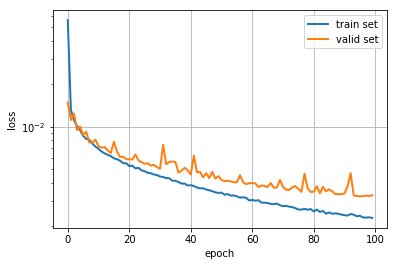

In [4]:
# Visualise

% matplotlib inline
from matplotlib import pyplot

pyplot.plot(hist.history['loss'],        # 训练集中训练样本损失函数
            linewidth=2, 
            label='train set')
pyplot.plot(hist.history['val_loss'], 
            linewidth=2,                 # 训练集中验证样本损失函数
            label='valid set')
pyplot.grid()                            # 显示刻度(x轴上的0,20,40等)
pyplot.legend()                          # 显示图例
pyplot.xlabel('epoch')                   # x轴标签
pyplot.ylabel('loss')                    # y轴标签
# pyplot.ylim(1e-3, 1e-2)                  # y轴显示范围
pyplot.yscale('log')                     # y轴刻度
pyplot.show()                            # 显示图表

## 预测结果

In [7]:
# prediction

X_test, _ = load(test=True)              # load() 返回(X,None)，用_丢弃None
y_test = model.predict(X_test)           # 用训练好的模型预测X_test

# 加运行时间

ImageId    1783
Image      1783
dtype: int64


image 546 to 562


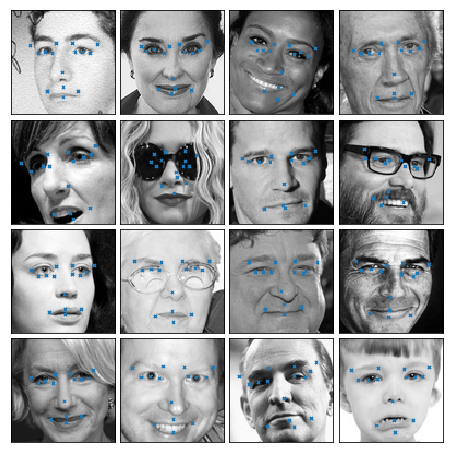

In [9]:
# show

from random import randint
from matplotlib import pyplot

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    hspace=0.05,
                    wspace=0.05)

numofImages = X_test.shape[0]
num = randint(0, numofImages-16)
print('image',num,'to',num+16)

for i in range(num, num+16):
    axis = fig.add_subplot(4, 4, i-num+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

### 保存、加载模型

In [10]:
# 保存模型：避免重复训练的时间

json_string = model.to_json()
open('model1_architecture.json', 'w').write(json_string)  # 模型结构信息
model.save_weights('model1_weights.h5')                   # 模型权重信息

# 载入模型

# from keras.models import model_from_json
# model = model_from_json(open('model1_architecture.json').read())
# model.load_weights('model1_weights.h5')

## 模型二 卷积神经网络

组成：卷积层，汇合层，全连接层

1. 卷积层学习结果：每个卷积核的权重
![Conv feature](image_2.gif)

2. 汇合层：通过平均值汇合或最大值汇合降低上一层尺寸、防止过度学习，以减少参数和计算复杂度
![MaxPooling](image_3.jpg)

3. 全连接层：即模型一中的隐层，与上一层所有神经元连接，上一层输出结果必须是一维数组

In [11]:
# 加载数据

# 输入值从9216像素转换成(1,96,96)【错，应为(96,96,1),tf顺序是NHWC】1表示灰度的1通道

def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 96, 96, 1)            # Image 转换格式，
    return X, y

X, y = load2d()                     # 转换数据格式
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
      X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
      y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [13]:
# Model 2: CNN

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# 网络结构：3个Conv2D(分别32,64,128卷积核) + 
#          2个maxPool2D(均为500神经元)
from keras.layers import Convolution2D, MaxPooling2D, Flatten
# Flatten层将多维数据一维化，用来连接卷积层Conv和全连接层Dense

model3 = Sequential()                       # 顺序网络对象

model3.add(Convolution2D(32, (3, 3),        # 32卷积核，3x3卷积
                  input_shape=(96, 96, 1))) # 输入shape（仅需这里）
model3.add(Activation('relu'))      # 激活函数
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2最大值汇合

model3.add(Convolution2D(64, (2, 2)))       # 64卷积核，2x2卷积(自动计算shape)
model3.add(Activation('relu'))              # 激活函数
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2最大值汇合

model3.add(Convolution2D(128, (2, 2)))      # 128卷积核，2x2卷积
model3.add(Activation('relu'))              # 激活函数
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2最大值汇合

model3.add(Flatten())               # 压平降到一维
model3.add(Dense(500))              # 全连接层，500神经元
model3.add(Activation('relu'))      # 激活函数
model3.add(Dense(500))              # 全连接层，500神经元
model3.add(Activation('relu'))      # 激活函数
model3.add(Dense(30))               # 全连接层，30神经元(15个点坐标)

sgd = SGD(lr=0.01,                # 自定义优化函数
          momentum=0.9, 
          nesterov=True)   
model3.compile(loss='mean_squared_error', # 损失函数
               optimizer=sgd)             # 优化器
model3.summary()                          # 显示网络结构
hist3 = model3.fit(X, y, 
                   epochs=20,           # 训练轮数
                   validation_split=0.2)  # 验证比例

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
activation_3 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

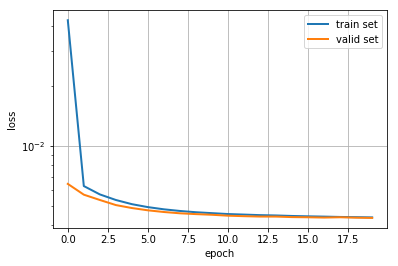

In [14]:
# Visualise

% matplotlib inline
from matplotlib import pyplot

pyplot.plot(hist3.history['loss'],       # 训练集中训练样本损失函数
            linewidth=2, 
            label='train set')
pyplot.plot(hist3.history['val_loss'], 
            linewidth=2,                 # 训练集中验证样本损失函数
            label='valid set')
pyplot.grid()                            # 显示刻度(x轴上的0,20,40等)
pyplot.legend()                          # 显示图例
pyplot.xlabel('epoch')                   # x轴标签
pyplot.ylabel('loss')                    # y轴标签
# pyplot.ylim(1e-3, 1e-2)                  # y轴显示范围
pyplot.yscale('log')                     # y轴刻度
pyplot.show()                            # 显示图表

In [15]:
# prediction

X_test, _ = load2d(test=True)             # 载入高维
y_test = model3.predict(X_test)           # 用训练好的模型预测X_test

ImageId    1783
Image      1783
dtype: int64


image 1631 to 1647


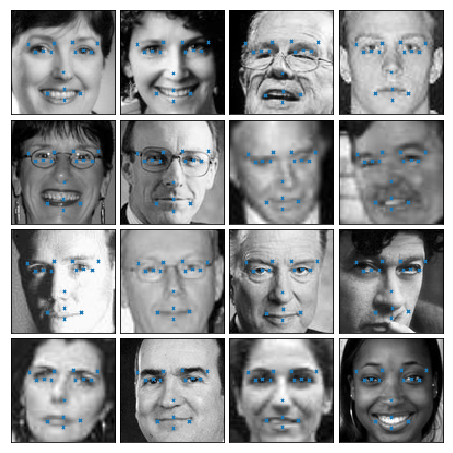

In [17]:
# show

from matplotlib import pyplot
from random import randint

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    hspace=0.05,
                    wspace=0.05)

numofImages = X_test.shape[0]
num = randint(0, numofImages-16)
print('image',num,'to',num+16)

for i in range(num, num+16):
    axis = fig.add_subplot(4, 4, i-num+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

In [18]:
# Compare 2 models

# Load All Samples

from matplotlib import pyplot
from random import randint

AllSample1 = load(test=True)[0]
AllSample2 = load2d(test=True)[0]

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


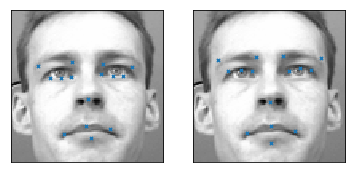

In [23]:
# predict both

num = randint(0, X_test.shape[0])
sample1 = AllSample1[num:num+1]
sample2 = AllSample2[num:num+1]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model3.predict(sample2)[0]

fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
pyplot.show()

In [21]:
# 保存模型：避免重复训练的时间

json_string = model3.to_json()
open('model3_architecture.json', 'w').write(json_string)  # 模型结构信息
model.save_weights('model3_weights.h5')                   # 模型权重信息

# 载入模型

# from keras.models import model_from_json
# model = model_from_json(open('model1_architecture.json').read())
# model.load_weights('model1_weights.h5')

## 数据扩增

常用的方法包括旋转、对称、添加噪声等